In [1]:
import os
import SimpleITK as sitk
import numpy as np
from utils import *
from convertRaw import *
import gvxrPython3 as gvxr
import json2gvxr
import matplotlib.pyplot as plt
from tifffile import imread, imsave # Load/Write TIFF files

SimpleGVXR 1.0.1 (2021-11-28T22:34:39) [Compiler: Microsoft Visual Studio] on Windows
gVirtualXRay core library (gvxr) 1.1.3 (2021-11-28T22:34:38) [Compiler: Microsoft Visual Studio] on Windows
SimpleGVXR 1.0.1 (2021-11-28T22:34:39) [Compiler: Microsoft Visual Studio] on Windows
gVirtualXRay core library (gvxr) 1.1.3 (2021-11-28T22:34:38) [Compiler: Microsoft Visual Studio] on Windows


# Configure gVirtualXRay environment

**Create an OpenGL context and window.**

In [2]:
json2gvxr.initGVXR("notebook-11.json", "OPENGL");

Create an OpenGL context: 512x512
Create an OpenGL context: 512x512


**Create a photon beam.**

In [3]:
json2gvxr.initSourceGeometry();

Set up the beam
	Source position: [0, -500, 0, 'mm']
	Source shape: ParallelBeam
Set up the beam
	Source position: [0, -500, 0, 'mm']
	Source shape: ParallelBeam


**Create a detector array.**

In [4]:
json2gvxr.initDetector("notebook-11.json");

Set up the detector
	Detector position: [0, 500, 0, 'mm']
	Detector up vector: [0, 0, -1]
	Detector number of pixels: [725, 426]
	Pixel spacing: [0.625, 0.7, 'mm']
Set up the detector
	Detector position: [0, 500, 0, 'mm']
	Detector up vector: [0, 0, -1]
	Detector number of pixels: [725, 426]
	Pixel spacing: [0.625, 0.7, 'mm']


In [5]:
gvxr.setMonoChromatic(100, "keV", 100);

**Create a phantom model from each mesh and its material.**

In [6]:
json2gvxr.initSamples("notebook-11.json", 1);

Load the 3D data

	Load 100HU_tumours in lungman_data/meshes/tumours_100HU.stl using mm
	Load -630HU_tumours in lungman_data/meshes/tumours_-630HU.stl using mm
	Load Clavicle in lungman_data/meshes/clavicle.stl using mm
	Load Heart in lungman_data/meshes/heart.stl using mm
Load the 3D data

	Load 100HU_tumours in lungman_data/meshes/tumours_100HU.stl using mm
	Load -630HU_tumours in lungman_data/meshes/tumours_-630HU.stl using mm
	Load Clavicle in lungman_data/meshes/clavicle.stl using mm
	Load Heart in lungman_data/meshes/heart.stl using mm
	Load Bronchus in lungman_data/meshes/bronchus.stl using mm
	Load Diaphram in lungman_data/meshes/diaphram.stl using mm
	Load Bronchus in lungman_data/meshes/bronchus.stl using mm
	Load Diaphram in lungman_data/meshes/diaphram.stl using mm
	Load Bronchioles in lungman_data/meshes/bronchioles.stl using mm
	Load Ribs_Spine in lungman_data/meshes/ribs_spine.stl using mm
	Load	Load Bronchioles in lungman_data/meshes/bronchioles.stl using mm
	Load Ribs_

**Rotate to achieve the desired orientation.**

In [7]:
gvxr.rotateScene(90, 0, 0, 1);

**Create a gVirtualXRay projection of the scene.**

In [8]:
xray_image = np.array(gvxr.computeXRayImage());

**Flat field the detector's image.**

In [9]:
# Create a mock dark field image
dark_field_image = np.zeros(xray_image.shape);

# Create a mock flat field image
flat_field_image = np.ones(xray_image.shape);

# Retrieve the total energy
total_energy = 0.0;
energy_bins = gvxr.getEnergyBins("keV");
photon_count_per_bin = gvxr.getPhotonCountEnergyBins();

for energy, count in zip(energy_bins, photon_count_per_bin):
    total_energy += energy * count;
flat_field_image *= total_energy;
    
# Apply the actual flat-field correction on the raw projections
xray_image = (xray_image - dark_field_image) / (flat_field_image - dark_field_image)

dark_field_image = None
flat_field_image = None

**Normalise the image with a minus log transform.**

In [10]:
# Make sure no value is negative or null (because of the log function)
# It should not be the case, however, when the Laplacian is used to simulate
# phase contrast, negative values can be generated.
threshold = 0.000000001
xray_image[xray_image < threshold] = threshold;

# Apply the minus log normalisation
xray_image = -np.log(xray_image);

# Rescale the data taking into account the pixel size
pixel_spacing_in_mm = gvxr.getDetectorSize("mm")[0] / gvxr.getDetectorNumberOfPixels()[0]
xray_image /= pixel_spacing_in_mm * (gvxr.getUnitOfLength("mm") / gvxr.getUnitOfLength("cm"));

# Make sure the data is in single-precision floating-point numbers
xray_image = np.array(xray_image).astype(np.single)

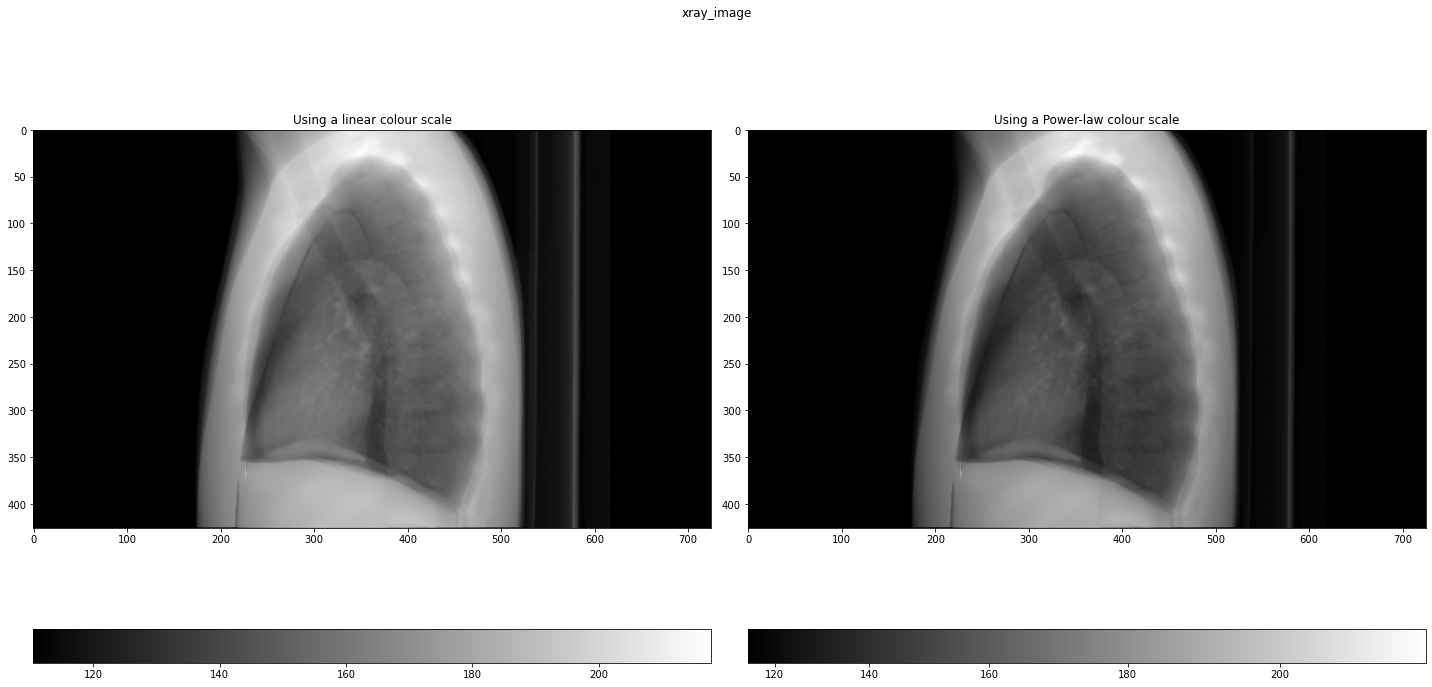

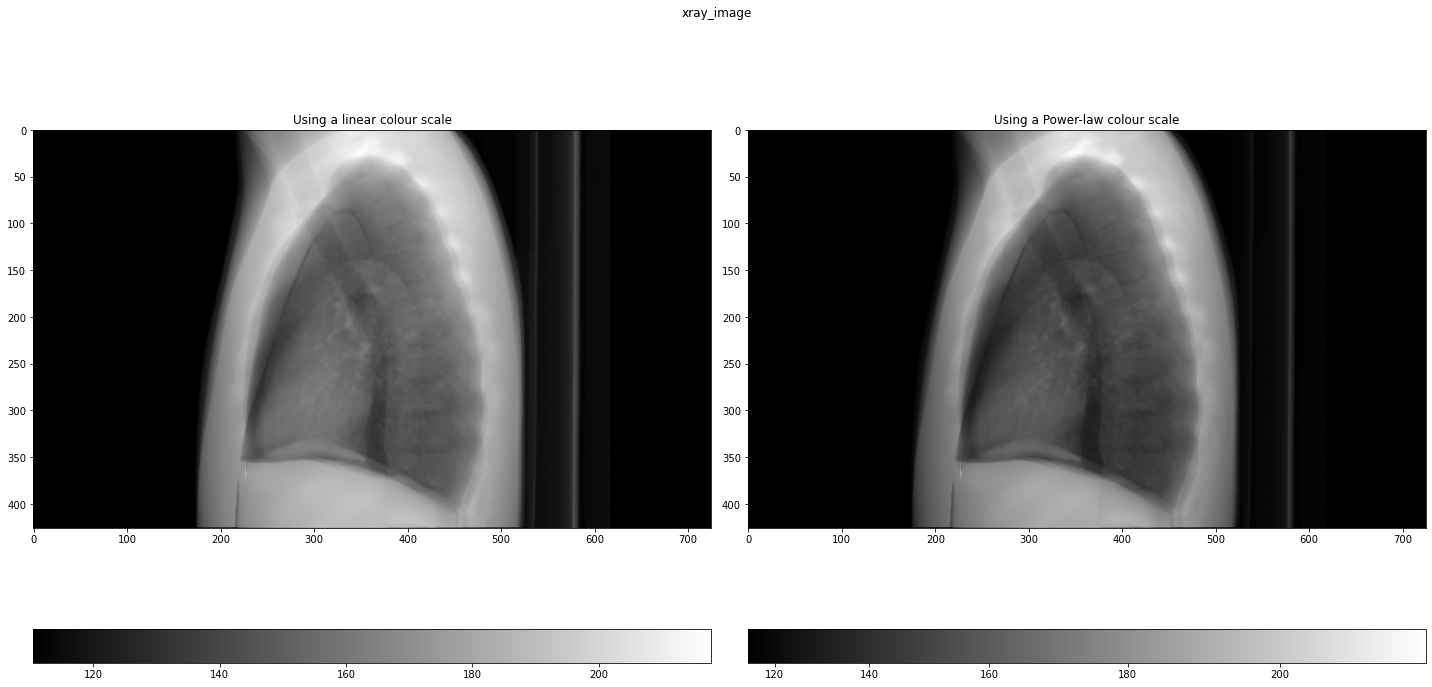

In [11]:
displayLinearPowerScales(xray_image, "xray_image", "plots/xray_image");

## Plastimatch Parameters
- Normal vector set to 1x,0y,0z or left to right (--nrm)
- Dectector up vector set to 0x,0x,1z (--vup)
- Reconstructed image dimensions 725 by 426 to match gvxr projection (-r)
- Detector size adjusted for spacing $725\times0.625$ by $426\times0.7$ (-z)
- Output type raw (-t)
- Source to detector and source to object set effectively to infinity, mimicking a parellel detector (--sid and --sad)

In [12]:
os.system('plastimatch drr --nrm "1 0 0" --vup "0 0 1" -r "725 426" -c "580 -57" -z "453.125 298.5" -t raw --sid 32767 --sad 32767 --output Plastimatch_data/lungman_DRR lungman_data/lungman.mha');

In [13]:
#os.system('python convertRaw.py "Plastimatch_data/lungman_DRR0000.raw" "Plastimatch_data/lungman_DRR.mha" "false" "sitkFloat32" 725 426');

image_DRR = read_raw(binary_file_name="Plastimatch_data/lungman_DRR0000.raw",
                 image_size=[725, 426],
                 sitk_pixel_type=sitk.sitkFloat32,
                 big_endian="false");

image_DRR = np.array(sitk.GetArrayFromImage(image_DRR));

[b'ObjectType = Image\n', b'NDims = 2\n', b'DimSize = 725 426\n', b'ElementSpacing = 1 1\n', b'Offset = 0 0\n', b'TransformMatrix = 1 0 0 1\n', b'ElementType = MET_FLOAT\n', b'BinaryData = True\n', b'BinaryDataByteOrderMSB = false\n', b'ElementDataFile = C:\\gvxr-12-25\\notebooks\\Plastimatch_data\\lungman_DRR0000.raw\n']
[b'ObjectType = Image\n', b'NDims = 2\n', b'DimSize = 725 426\n', b'ElementSpacing = 1 1\n', b'Offset = 0 0\n', b'TransformMatrix = 1 0 0 1\n', b'ElementType = MET_FLOAT\n', b'BinaryData = True\n', b'BinaryDataByteOrderMSB = false\n', b'ElementDataFile = C:\\gvxr-12-25\\notebooks\\Plastimatch_data\\lungman_DRR0000.raw\n']


In [14]:
#----------------------------------------------------REMEMBER TO CHANGE THIS TO TIFF AND USE IMREAD
sitk_reader = sitk.ImageFileReader();
sitk_reader.SetImageIO("MetaImageIO");

sitk_reader.SetFileName("gVirtualXRay_output_data/gvxr_lungman_1-0-0_radiograph_normalised_402.mha");
image_gvxr = np.array(sitk.GetArrayFromImage(sitk_reader.Execute()));

min = np.min(image_DRR);
max = np.max(image_DRR);
image_DRR -= min;
image_DRR /= (max -min);

image_gvxr[image_gvxr < 0.00001] = 0.00001;
image_DRR[image_DRR < 0.00001] = 0.00001;

print(np.min(image_DRR))
print(np.max(image_DRR))
print(np.min(image_gvxr))
print(np.max(image_gvxr))

print(np.mean(image_gvxr));
print(np.mean(image_DRR));


1e-05
1.0
1e-05
1.0036262
0.23936102
0.24296822
1e-05
1.0
1e-05
1.0036262
0.23936102
0.24296822


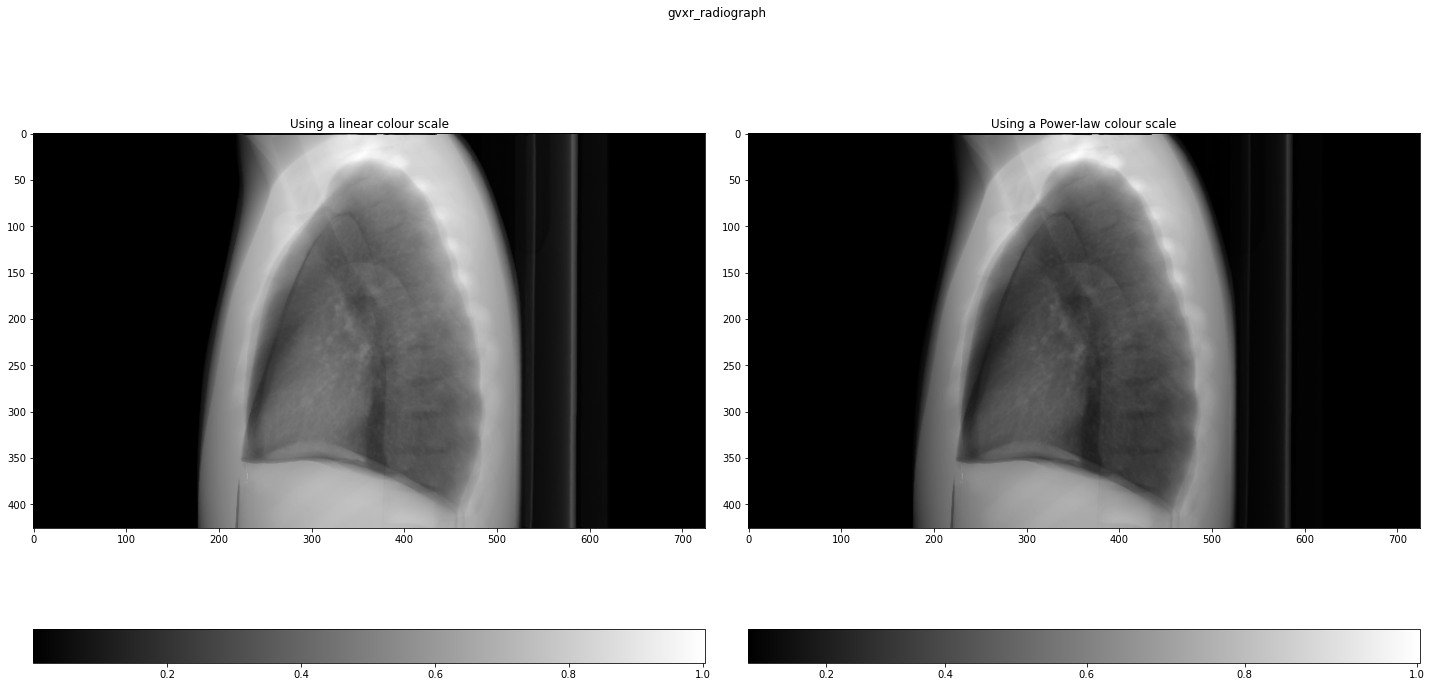

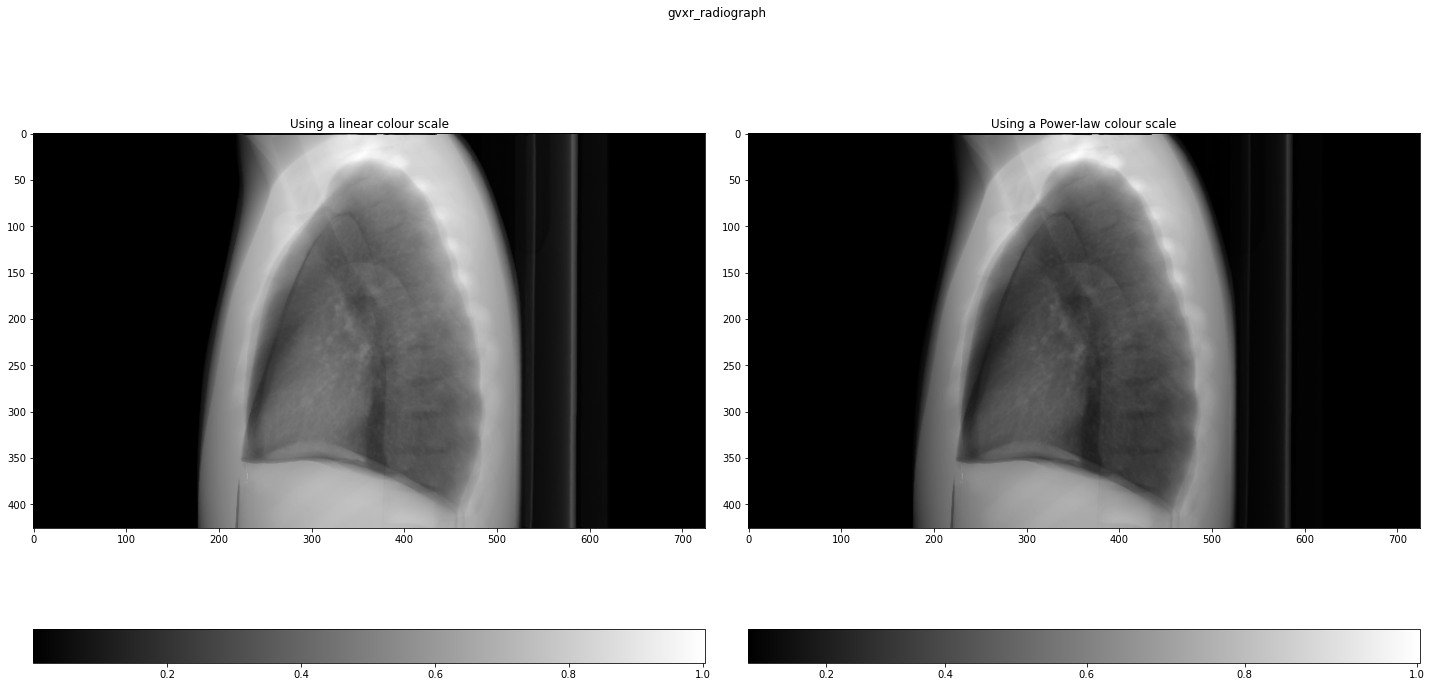

In [15]:
displayLinearPowerScales(image_gvxr, "gvxr_radiograph", "plots/lungman_gvxr_radiograph")

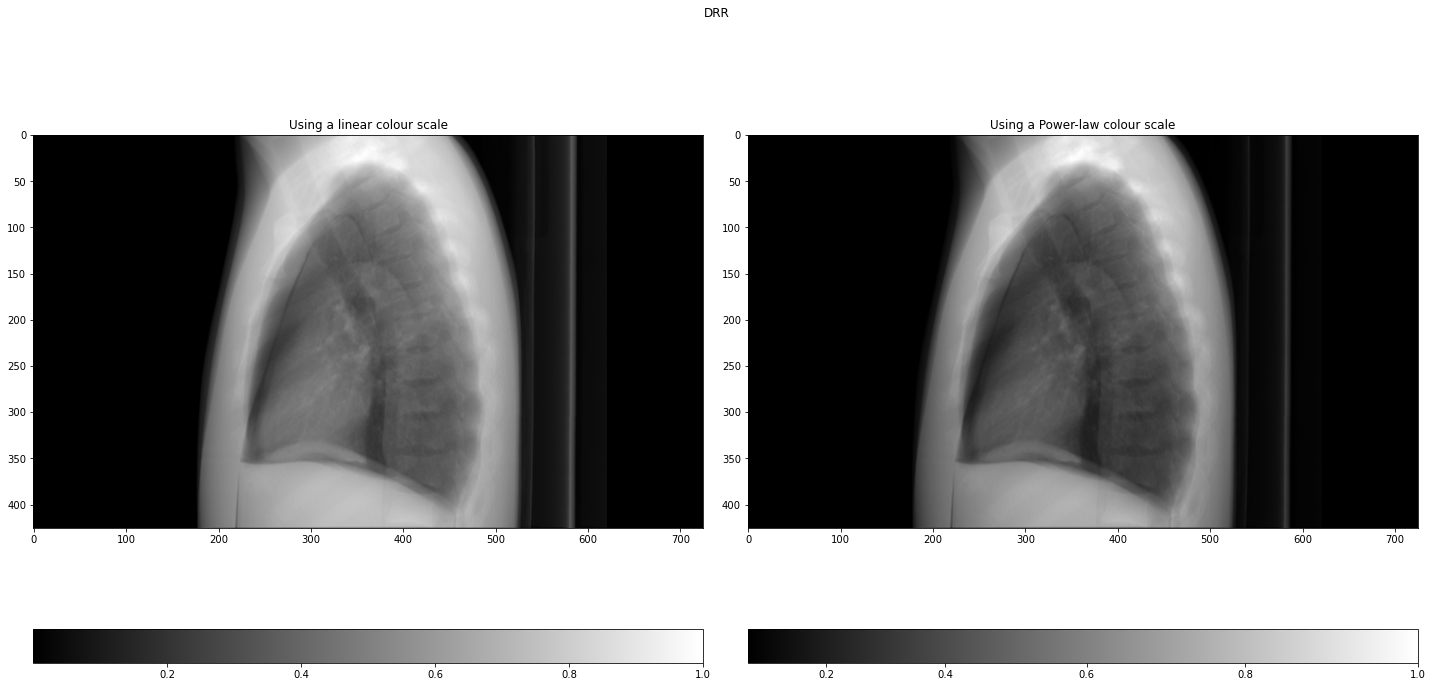

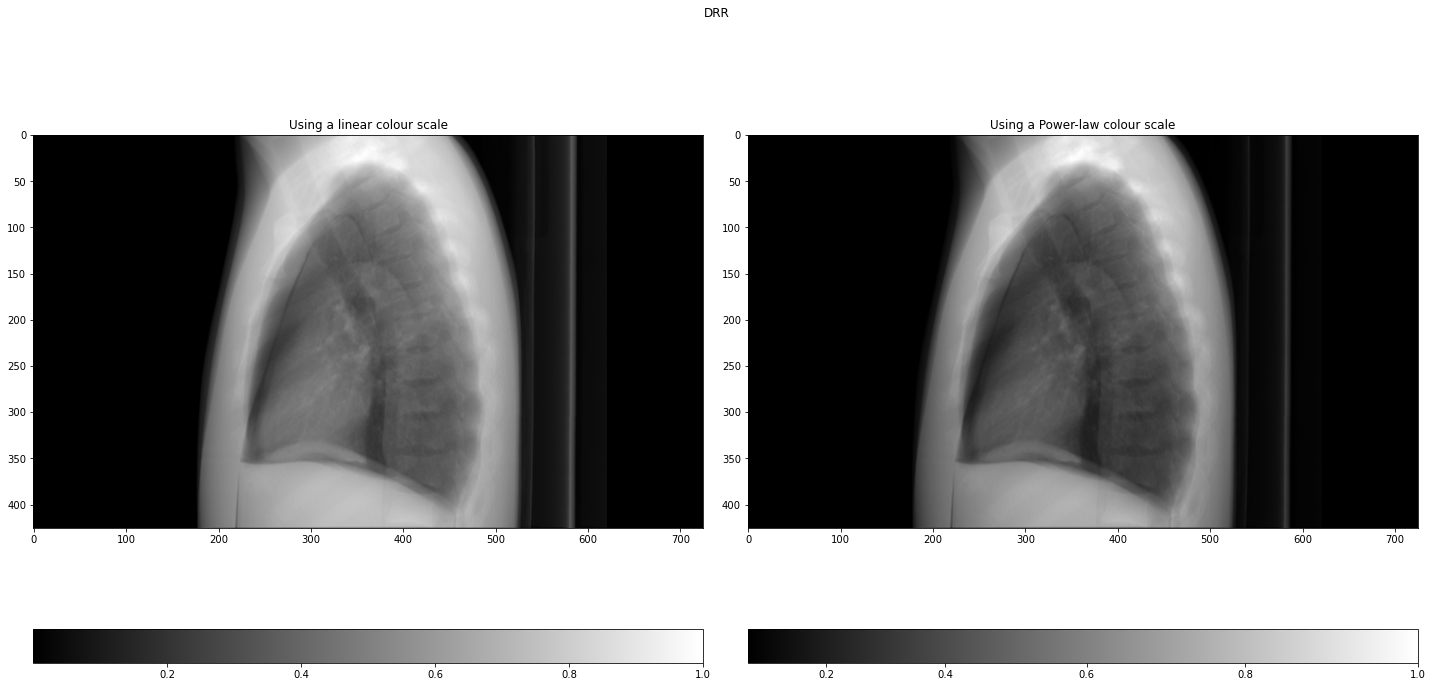

In [16]:
displayLinearPowerScales(image_DRR, "DRR", "plots/lungman_DRR")

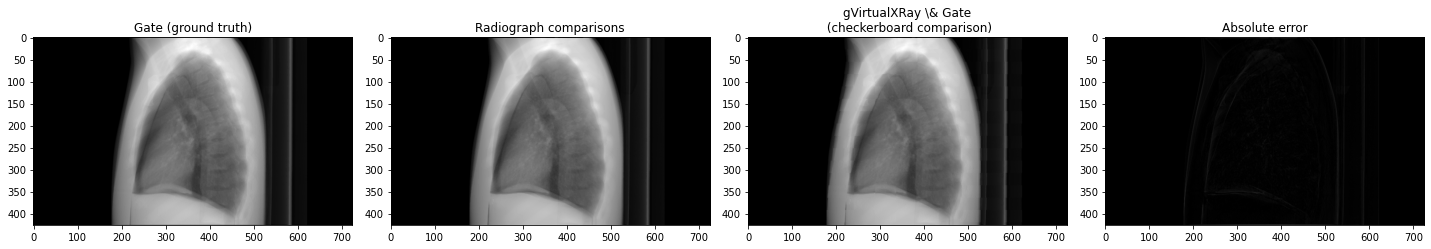

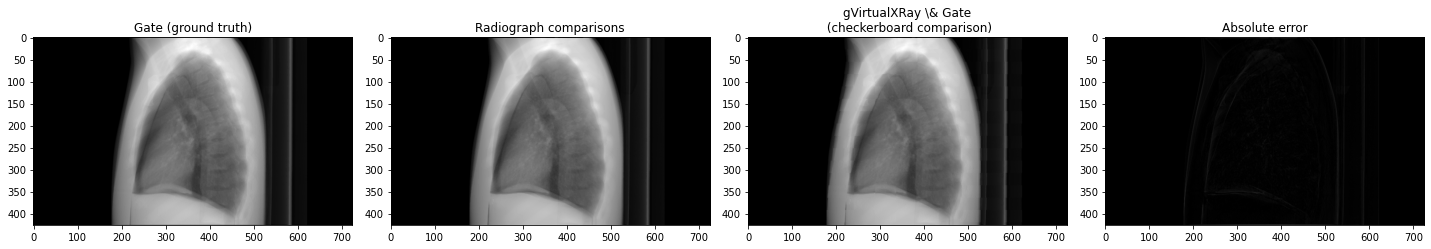

In [17]:
fullCompareImages(image_DRR, image_gvxr, "Radiograph comparisons","plots/lungman_full_comparison_radiographs");